In [443]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('missing').getOrCreate()
from pyspark.ml.classification import LogisticRegression

In [450]:
df = spark.read.csv('Dataset/Bank.csv',header=True,inferSchema=True)
Pdf=df.toPandas()

In [448]:
# The show method allows you visualise DataFrames in a tabular format. 
df.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+---+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+-------+
|age|        job| marital|          education|default|housing|loan|  contact|month|day|duration|campaign|pdays|previous|   poutcome|emp var rate|cons price idx|cons conf idx|euribor3m|nr employed|Deposit|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+---+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+-------+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|     no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.

In [452]:
Pdf.head()

,age,job,marital,education,default,housing,loan,contact,month,day,...,campaign,pdays,previous,poutcome,emp var rate,cons price idx,cons conf idx,euribor3m,nr employed,Deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [453]:
# Print schema allows us to visualise the data structure at a high level. 
df.printSchema()

# We can also use head to print a specific amount of rows, so we can get a better understanding of the data points. 
# Note that we have to specify 'print' depending on the method we're using. Otherwise it may not show up!
print(df.head(2))


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp var rate: double (nullable = true)
 |-- cons price idx: double (nullable = true)
 |-- cons conf idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr employed: double (nullable = true)
 |-- Deposit: string (nullable = true)

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day='mon', dura

In [454]:
# We can use the describe method get some general statistics on our data too. 
df.select('Deposit').describe().show()

+-------+-------+
|summary|Deposit|
+-------+-------+
|  count|  41188|
|   mean|   null|
| stddev|   null|
|    min|     no|
|    max|    yes|
+-------+-------+



In [455]:
Pdf.head()

,age,job,marital,education,default,housing,loan,contact,month,day,...,campaign,pdays,previous,poutcome,emp var rate,cons price idx,cons conf idx,euribor3m,nr employed,Deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [456]:
# For integer type features, you may want to replace the null value the average of that feature.
# Let's see how that's done using balance as an example.
from pyspark.sql.functions import mean

# Let's find the average. But the problem is, how do we get that information out of the DataFrame?
mean_campaign = df.select(mean('campaign')).show()

+-----------------+
|    avg(campaign)|
+-----------------+
|2.567633847274493|
+-----------------+



In [457]:
Pdf['campaign']=Pdf['campaign'].fillna(Pdf['campaign'].mean())

In [458]:
Pdf.head(20)

,age,job,marital,education,default,housing,loan,contact,month,day,...,campaign,pdays,previous,poutcome,emp var rate,cons price idx,cons conf idx,euribor3m,nr employed,Deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1.000000,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
#Pie Plot

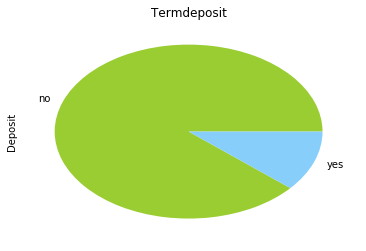

In [459]:
# plot data
colors = ['yellowgreen','lightskyblue']
Pdf['Deposit'].value_counts().plot(kind='pie',title='Termdeposit',colors=colors)
plt.show()


In [ ]:
#Histogram

Text(0.5,0,'deposit')

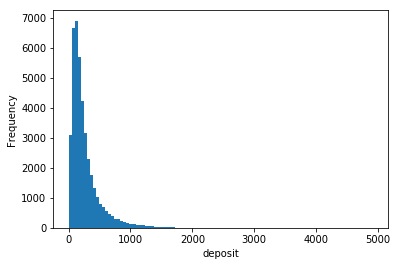

In [460]:
Pdf['duration'].plot(kind='hist',bins=100)
plt.xlabel('deposit')

In [ ]:
#Histogram

<Figure size 432x288 with 0 Axes>

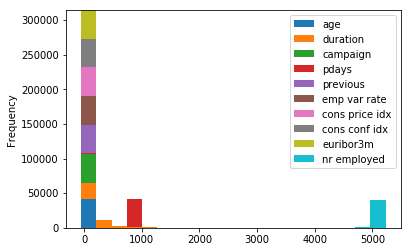

In [461]:
plt.figure();

Pdf.plot.hist(stacked=True, bins=20)

In [ ]:
#Horizontal and cumulative histogram

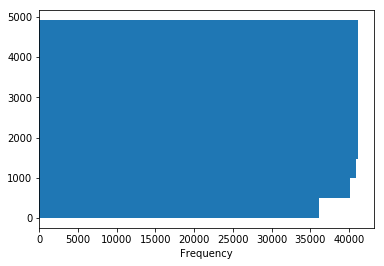

In [462]:

plt.figure();
Pdf['duration'].plot.hist(orientation='horizontal', cumulative=True)

In [ ]:
#Boxplot


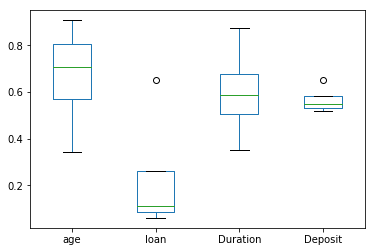

In [463]:
Pdf = pd.DataFrame(np.random.rand(4,4), columns=['age', 'loan', 'Duration', 'Deposit'])

Pdf.plot.box()

In [469]:
Pdf=df.toPandas()

In [470]:
Pdf.head()

,age,job,marital,education,default,housing,loan,contact,month,day,...,campaign,pdays,previous,poutcome,emp var rate,cons price idx,cons conf idx,euribor3m,nr employed,Deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [471]:

Pdf.drop(['job','marital','education','cons conf idx','housing'],axis=1)


,age,default,loan,contact,month,day,duration,campaign,pdays,previous,poutcome,emp var rate,cons price idx,euribor3m,nr employed,Deposit
0,56,no,no,telephone,may,mon,261,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
1,57,unknown,no,telephone,may,mon,149,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
2,37,no,no,telephone,may,mon,226,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
3,40,no,no,telephone,may,mon,151,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
4,56,no,yes,telephone,may,mon,307,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
5,45,unknown,no,telephone,may,mon,198,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
6,59,no,no,telephone,may,mon,139,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
7,41,unknown,no,telephone,may,mon,217,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
8,24,no,no,telephone,may,mon,380,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no
9,25,no,no,telephone,may,mon,50,1.0,999,0,nonexistent,1.1,93.994,4.857,5191.0,no


In [477]:
sdf = spark.createDataFrame(Pdf)

In [478]:
sdf=sdf.drop('job','marital','education','cons conf idx','housing')

In [479]:
sdf.show()

+---+-------+----+---------+-----+---+--------+--------+-----+--------+-----------+------------+--------------+---------+-----------+-------+
|age|default|loan|  contact|month|day|duration|campaign|pdays|previous|   poutcome|emp var rate|cons price idx|euribor3m|nr employed|Deposit|
+---+-------+----+---------+-----+---+--------+--------+-----+--------+-----------+------------+--------------+---------+-----------+-------+
| 56|     no|  no|telephone|  may|mon|     261|     1.0|  999|       0|nonexistent|         1.1|        93.994|    4.857|     5191.0|     no|
| 57|unknown|  no|telephone|  may|mon|     149|     1.0|  999|       0|nonexistent|         1.1|        93.994|    4.857|     5191.0|     no|
| 37|     no|  no|telephone|  may|mon|     226|     1.0|  999|       0|nonexistent|         1.1|        93.994|    4.857|     5191.0|     no|
| 40|     no|  no|telephone|  may|mon|     151|     1.0|  999|       0|nonexistent|         1.1|        93.994|    4.857|     5191.0|     no|
| 56| 

In [480]:
from pyspark.ml.feature import (VectorAssembler, StringIndexer, VectorIndexer, OneHotEncoder)

In [481]:
# First create a string indexer which converts every string into a number, such as male = 0 and female = 1.
# A number will be assigned to every category in the column.
loan_indexer = StringIndexer(inputCol='loan',outputCol='loanIndex')
contact_indexer = StringIndexer(inputCol='contact',outputCol='contactIndex')
month_indexer = StringIndexer(inputCol='month',outputCol='monthIndex')
day_indexer = StringIndexer(inputCol='day',outputCol='day_Index')
default_indexer = StringIndexer(inputCol='default',outputCol='defaultIndex')
poutcome_indexer = StringIndexer(inputCol='poutcome',outputCol='poutcomeIndex')
Deposit_indexer = StringIndexer(inputCol='Deposit',outputCol='label')

In [482]:
# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
loan_encoder = OneHotEncoder(inputCol='loanIndex',outputCol='loanVec')
contact_encoder = OneHotEncoder(inputCol='contactIndex',outputCol='contactVec')
month_encoder = OneHotEncoder(inputCol='monthIndex',outputCol='monthVec')
day_encoder = OneHotEncoder(inputCol='day_Index',outputCol='dayVec')
default_encoder = OneHotEncoder(inputCol='defaultIndex',outputCol='defaultVec')
poutcome_encoder = OneHotEncoder(inputCol='poutcomeIndex',outputCol='poutcomeVec')



In [483]:
# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['loanVec','contactVec','monthVec','defaultVec',
                                       'dayVec','poutcomeVec',
                                       'age', 'duration', 'campaign', 'pdays',
                                       'previous','emp var rate','euribor3m','nr employed'], outputCol="Bankmarket")

In [484]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[loan_indexer, contact_indexer, month_indexer, day_indexer,
                            default_indexer, poutcome_indexer, Deposit_indexer,loan_encoder,
                            contact_encoder, month_encoder ,day_encoder,default_encoder,
                           poutcome_encoder, assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(sdf)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(sdf)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'Bankmarket')

In [486]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='Bankmarket',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)

Training Dataset Count: 28727
Test Dataset Count: 12461


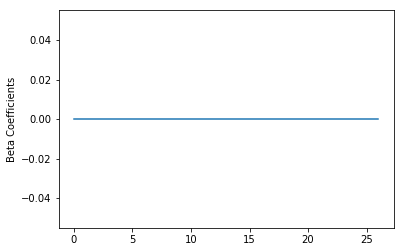

In [487]:

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

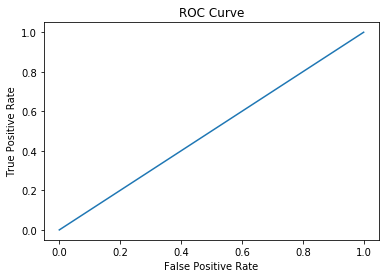

Area Under the Curve: 0.5


In [488]:
# Let's get a summary of the data.
training_summary = lr_model.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

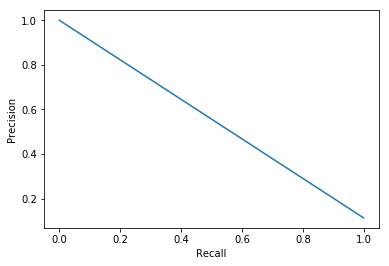

In [489]:
# Convert DataFrame to Pandas DataFrame.
pr = training_summary.pr.toPandas()

# Plot model recall and precision.
plt.plot(pr['recall'],pr['precision'])

# Define the labels and show the graph. 
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()